In [1]:
from __future__ import division #, print_function # Imports from __future__ since we're running Python 2
import os
import numpy as np 
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.cross_validation import train_test_split
from sklearn.linear_model import LinearRegression
from helpers.my_one_hot_encoder import MyOneHotEncoder
from sklearn.utils import shuffle
from sklearn.cross_validation import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.tree import DecisionTreeClassifier, export_graphviz
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, confusion_matrix, r2_score

random_state = 0 # Ensure reproducible results
%matplotlib inline
plt.style.use('ggplot')

C:\Users\lmano\Anaconda2\envs\iaml\lib\site-packages\sklearn\cross_validation.py:44: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. Also note that the interface of the new CV iterators are different from that of this module. This module will be removed in 0.20.
  "This module will be removed in 0.20.", DeprecationWarning)


# Flying to New York City - Linear Regression

In [2]:
path_data = os.path.realpath(os.path.join(os.getcwd(), 'clear_data_holiday.csv'))
assert os.path.isfile(path_data)
path_data

'C:\\Users\\lmano\\Documents\\UoE\\2. DME\\DME project\\clear_data_holiday.csv'

In [3]:
data = pd.read_csv(path_data, delimiter = ',', index_col=None, header=0)
#all_pandas.append(data_full)
#data_frame = pd.concat(all_pandas)
data.shape

(479820, 34)

### Subsample the dataset to be able to handle the data in LR and find most important weights

In [4]:
temp = data.groupby('ARR_DELAY_GROUP')['ARR_DELAY'].count()

In [5]:
upcoming_flights = data[data['ORIGIN_STATE_ABR'] != 'NY']

In [6]:
upcoming_flights.loc[upcoming_flights['ARR_DELAY_GROUP'] < 0, 'ARR_DELAY_GROUP'] = 0

C:\Users\lmano\Anaconda2\envs\iaml\lib\site-packages\pandas\core\indexing.py:465: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self.obj[item] = s


In [7]:
nondelayed = upcoming_flights[upcoming_flights['ARR_DELAY_GROUP'] == 0]

In [8]:
delayed = upcoming_flights[upcoming_flights['ARR_DELAY_GROUP'] > 0]

In [9]:
non_delayed_short = shuffle(nondelayed, random_state = random_state, n_samples = int(len(delayed)/2))

In [10]:
flights = shuffle(pd.concat((delayed, non_delayed_short)), random_state = random_state)

In [11]:
print("There are {} entries and {} columns in the DataFrame"\
      .format(flights.shape[0], flights.shape[1]))

There are 78997 entries and 34 columns in the DataFrame


In [12]:
print("There are {} entries and {} columns in the DataFrame"\
      .format(flights.shape[0], flights.shape[1]))

There are 78997 entries and 34 columns in the DataFrame


### Fix the data for Linear Regression task

In [13]:
flights.columns

Index([u'QUARTER', u'MONTH', u'DAY_OF_MONTH', u'DAY_OF_WEEK', u'FL_DATE',
       u'UNIQUE_CARRIER', u'ORIGIN', u'ORIGIN_CITY_NAME', u'ORIGIN_STATE_ABR',
       u'ORIGIN_STATE_NM', u'DEST', u'DEST_CITY_NAME', u'DEST_STATE_ABR',
       u'DEST_STATE_NM', u'CRS_DEP_TIME', u'DEP_TIME', u'DEP_DELAY',
       u'DEP_DEL15', u'DEP_DELAY_GROUP', u'DEP_TIME_BLK', u'CRS_ARR_TIME',
       u'ARR_TIME', u'ARR_DELAY', u'ARR_DEL15', u'ARR_DELAY_GROUP',
       u'CRS_ELAPSED_TIME', u'ACTUAL_ELAPSED_TIME', u'DISTANCE',
       u'DISTANCE_GROUP', u'IS_HOLIDAY', u'DAYS_TO_NEXT_HOLIDAY',
       u'DAYS_FROM_LAST_HOLIDAY', u'DAYS_FROM_NEAREST_HOLIDAY',
       u'WEEK_OF_YEAR'],
      dtype='object')

In [14]:
flights_dropped = flights.drop(['ORIGIN_STATE_ABR', 'DEST_STATE_ABR', 'CRS_DEP_TIME', 'CRS_ELAPSED_TIME', 'ACTUAL_ELAPSED_TIME', 'CRS_ARR_TIME'], axis=1)

In [15]:
flights_dropped = flights_dropped.drop(['FL_DATE'],axis=1)

In [16]:
# np.sum(flights_dropped.isnull())
flights_dropped.shape


(78997, 27)

In [17]:
flights_dropped.columns

Index([u'QUARTER', u'MONTH', u'DAY_OF_MONTH', u'DAY_OF_WEEK',
       u'UNIQUE_CARRIER', u'ORIGIN', u'ORIGIN_CITY_NAME', u'ORIGIN_STATE_NM',
       u'DEST', u'DEST_CITY_NAME', u'DEST_STATE_NM', u'DEP_TIME', u'DEP_DELAY',
       u'DEP_DEL15', u'DEP_DELAY_GROUP', u'DEP_TIME_BLK', u'ARR_TIME',
       u'ARR_DELAY', u'ARR_DEL15', u'ARR_DELAY_GROUP', u'DISTANCE',
       u'DISTANCE_GROUP', u'IS_HOLIDAY', u'DAYS_TO_NEXT_HOLIDAY',
       u'DAYS_FROM_LAST_HOLIDAY', u'DAYS_FROM_NEAREST_HOLIDAY',
       u'WEEK_OF_YEAR'],
      dtype='object')

In [18]:
def one_hot(df, cols):
    """
    @param df pandas DataFrame
    @param cols a list of columns to encode 
    @return a DataFrame with one-hot encoding
    """
    for each in cols:
        dummies = pd.get_dummies(df[each], prefix=each, drop_first=False)
        df = pd.concat([df, dummies], axis=1)
    return df

In [19]:
columns_one_hot = ['DEP_TIME_BLK', 'MONTH', 'DAY_OF_MONTH', 'DAY_OF_WEEK', 'ORIGIN_STATE_NM', 'UNIQUE_CARRIER', 'DEST', 'DEP_DELAY_GROUP',
                  'DISTANCE_GROUP']

In [23]:
flights_dropped2 = flights_dropped.drop(['QUARTER', 'MONTH', 'DAY_OF_MONTH', 'DAY_OF_WEEK', 'UNIQUE_CARRIER', 'ORIGIN', 'ORIGIN_CITY_NAME', 
       'ORIGIN_STATE_NM', 'DEST', 'DEST_CITY_NAME', 
       'DEST_STATE_NM', 'DEP_TIME', 'DEP_DELAY',
       'DEP_DEL15', 'DEP_DELAY_GROUP', 'DEP_TIME_BLK', 'ARR_TIME',  
       'DISTANCE', 'DISTANCE_GROUP', 'WEEK_OF_YEAR'], axis=1)


In [24]:
flights_dropped2.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 78997 entries, 112086 to 118325
Data columns (total 7 columns):
ARR_DELAY                    78997 non-null float64
ARR_DEL15                    78997 non-null float64
ARR_DELAY_GROUP              78997 non-null float64
IS_HOLIDAY                   78997 non-null float64
DAYS_TO_NEXT_HOLIDAY         78997 non-null float64
DAYS_FROM_LAST_HOLIDAY       78997 non-null float64
DAYS_FROM_NEAREST_HOLIDAY    78997 non-null float64
dtypes: float64(7)
memory usage: 4.8 MB


In [25]:
df_hot = one_hot(flights_dropped, columns_one_hot)

In [26]:
df_hot = df_hot.drop(['QUARTER', 'MONTH', 'DAY_OF_MONTH', 'DAY_OF_WEEK', 'UNIQUE_CARRIER', 'ORIGIN', 'ORIGIN_CITY_NAME', 
       'ORIGIN_STATE_NM', 'DEST', 'DEST_CITY_NAME', 
       'DEST_STATE_NM', 'DEP_TIME', 'DEP_DELAY',
       'DEP_DEL15', 'DEP_DELAY_GROUP', 'DEP_TIME_BLK', 'ARR_TIME',  
       'DISTANCE', 'DISTANCE_GROUP', 'WEEK_OF_YEAR'], axis=1)

In [27]:
df_hot.shape

(78997, 167)

In [ ]:
ARR_DELAY                    78997 non-null float64
ARR_DEL15                    78997 non-null float64
ARR_DELAY_GROUP              78997 non-null float64
IS_HOLIDAY                   78997 non-null float64
DAYS_TO_NEXT_HOLIDAY         78997 non-null float64
DAYS_FROM_LAST_HOLIDAY       78997 non-null float64
DAYS_FROM_NEAREST_HOLIDAY    78997 non-null float64

In [28]:
df_hot.columns

Index([u'ARR_DELAY', u'ARR_DEL15', u'ARR_DELAY_GROUP', u'IS_HOLIDAY',
       u'DAYS_TO_NEXT_HOLIDAY', u'DAYS_FROM_LAST_HOLIDAY',
       u'DAYS_FROM_NEAREST_HOLIDAY', u'DEP_TIME_BLK_0001-0559',
       u'DEP_TIME_BLK_0600-0659', u'DEP_TIME_BLK_0700-0759',
       ...
       u'DISTANCE_GROUP_2', u'DISTANCE_GROUP_3', u'DISTANCE_GROUP_4',
       u'DISTANCE_GROUP_5', u'DISTANCE_GROUP_6', u'DISTANCE_GROUP_7',
       u'DISTANCE_GROUP_8', u'DISTANCE_GROUP_9', u'DISTANCE_GROUP_10',
       u'DISTANCE_GROUP_11'],
      dtype='object', length=167)

In [ ]:
# 'ARR_DEL15', 'ARR_DELAY_GROUP' 'ARR_DELAY'

In [29]:
df_hot2 = df_hot.drop(['ARR_DELAY_GROUP', 'ARR_DEL15', 'DAYS_TO_NEXT_HOLIDAY', 
                       'DAYS_FROM_LAST_HOLIDAY', 'DAYS_FROM_NEAREST_HOLIDAY'],axis=1)

In [30]:
df_hot2.shape

(78997, 162)

In [31]:
X = df_hot2.drop('ARR_DELAY', axis=1) # Input features (attributes)
y = df_hot2['ARR_DELAY'] # Target vector
print('X shape: {}'.format(np.shape(X)))
print('y shape: {}'.format(np.shape(y)))

X shape: (78997, 161)
y shape: (78997L,)


In [32]:
X_train, X_test, y_train, y_test = train_test_split(X, y, train_size = 0.8, test_size=0.2, random_state=0)

In [33]:
print('Number of instances in X: {}'.format(np.shape(X)[0]))
print('Number of instances in X_train: {}'.format(X_train.shape[0]))
print('Number of instances in X_test: {}'.format(X_test.shape[0]))
print('Number of instances in X_train and X_test together: {}'.format(X_train.shape[0] + X_test.shape[0]))

Number of instances in X: 78997
Number of instances in X_train: 63197
Number of instances in X_test: 15800
Number of instances in X_train and X_test together: 78997


In [72]:
### save the created data
clear_data_path = os.path.realpath(os.path.join(os.getcwd(), 'X_train.csv'))
X_train.to_csv(clear_data_path, index=False)
clear_data_path = os.path.realpath(os.path.join(os.getcwd(), 'y_train.csv'))
y_train.to_csv(clear_data_path, index=False)

In [73]:
### save the created data
clear_data_path = os.path.realpath(os.path.join(os.getcwd(), 'X_test.csv'))
X_test.to_csv(clear_data_path, index=False)
clear_data_path = os.path.realpath(os.path.join(os.getcwd(), 'y_test.csv'))
y_test.to_csv(clear_data_path, index=False)

In [34]:
X_train = X_train.as_matrix()
X_test = X_test.as_matrix()
y_train = y_train.as_matrix()
y_test = y_test.as_matrix()

In [35]:
print('Number of instances in X: {}'.format(np.shape(X)[0]))
print('Number of instances in X_train: {}'.format(X_train.shape[0]))
print('Number of instances in X_test: {}'.format(X_test.shape[0]))
print('Number of instances in X_train and X_test together: {}'.format(X_train.shape[0] + X_test.shape[0]))

Number of instances in X: 78997
Number of instances in X_train: 63197
Number of instances in X_test: 15800
Number of instances in X_train and X_test together: 78997


## Linear Regression

In [54]:
sc = StandardScaler().fit(X_train)
X_train_sc = sc.transform(X_train)
X_test_sc = sc.transform(X_test)

In [55]:
lm = LinearRegression(fit_intercept=True, normalize=True, copy_X=True)
lm.fit(X_train_sc, y_train)
print('Training accuracy: {:.3f}'.format(lm.score(X_train_sc, y_train)))
print('Testing accuracy by using score function: {:.3f}'.format(lm.score(X_test_sc, y_test)))
print('Testing accuracy by using r2_score meric: {:.3f}'.format(r2_score(y_test, lm.predict(X_test_sc))))

Training accuracy: 0.864
Testing accuracy by using score function: -29843542050964846411776.000
Testing accuracy by using r2_score meric: -29843542050964846411776.000


In [56]:
lm.intercept_ 

37.69889814560004

In [57]:
lm.coef_ 

array([ -2.23352162e-01,  -1.69404410e+11,  -3.33753639e+11,
        -3.50958132e+11,  -2.94478869e+11,  -3.34029083e+11,
        -3.64668325e+11,  -3.93572864e+11,  -3.82628318e+11,
        -4.14871787e+11,  -3.67715149e+11,  -4.00739467e+11,
        -3.98633858e+11,  -4.48040139e+11,  -3.71455089e+11,
        -4.01481674e+11,  -3.69906667e+11,  -3.30983935e+11,
        -2.89770039e+11,  -2.36566815e+11,   2.29186288e+12,
         2.41496121e+12,   2.43549558e+12,   2.28258340e+12,
         2.33685165e+12,   2.55760851e+12,   2.64895740e+12,
         2.58073464e+12,   2.28524001e+12,   2.23173327e+12,
         2.30895912e+12,   2.32047576e+12,  -1.25705942e+13,
        -1.22536966e+13,  -1.20489353e+13,  -1.20371146e+13,
        -1.20548406e+13,  -1.18310944e+13,  -1.22855195e+13,
        -1.27989182e+13,  -1.21342430e+13,  -1.20430266e+13,
        -1.26602621e+13,  -1.19032125e+13,  -1.19688883e+13,
        -1.25085176e+13,  -1.29140592e+13,  -1.31274607e+13,
        -1.23746989e+13,

In [40]:
weights = lm.coef_

In [41]:
np.sort(weights)

array([ -1.17068129e+15,  -9.63984031e+13,  -9.47627959e+13,
        -4.42369486e+13,  -3.51760237e+13,  -3.33011470e+13,
        -2.84732908e+13,  -2.54168622e+13,  -2.39677555e+13,
        -2.02478986e+13,  -1.97957382e+13,  -1.92123766e+13,
        -1.54422799e+13,  -1.49227483e+13,  -1.34247062e+13,
        -1.32127596e+13,  -1.31274607e+13,  -1.29276873e+13,
        -1.29140592e+13,  -1.28621197e+13,  -1.28456671e+13,
        -1.27989182e+13,  -1.26602621e+13,  -1.25705942e+13,
        -1.25085176e+13,  -1.24175869e+13,  -1.23746989e+13,
        -1.23057215e+13,  -1.22855195e+13,  -1.22536966e+13,
        -1.22362987e+13,  -1.21342430e+13,  -1.20784292e+13,
        -1.20548406e+13,  -1.20489353e+13,  -1.20430266e+13,
        -1.20371146e+13,  -1.19688883e+13,  -1.19121925e+13,
        -1.19032125e+13,  -1.18521802e+13,  -1.18491705e+13,
        -1.18310944e+13,  -1.16945147e+13,  -1.16891488e+13,
        -1.16332308e+13,  -1.07018708e+13,  -1.04187777e+13,
        -1.00393113e+13,

In [42]:
def fit_scatter(y_true, y_pred):
    assert y_true.shape == y_pred.shape
    fig, ax = plt.subplots()
    ax.scatter(y_true, y_pred)
    ax.plot([y_true.min(), y_true.max()], [y_true.min(), y_true.max()], 'k--', lw=4)
    ax.set_xlabel('Measured')
    ax.set_ylabel('Predicted')

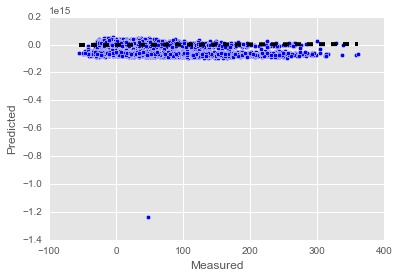

In [43]:
prediction = lm.predict(X_test)
fit_scatter(y_test, prediction)

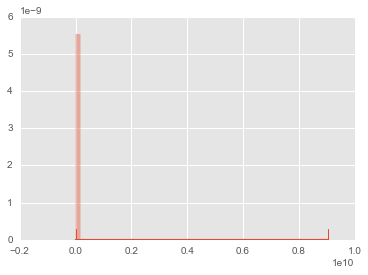

In [81]:
g = sns.distplot(y_test-prediction, rug=True)

In [51]:
#clear_data_path = os.path.realpath(os.path.join(os.getcwd(), 'clear_data_holiday.csv'))
#data_frame.to_csv(clear_data_path, index=False)